In [12]:
import abacus_cosmos.Halos as ach
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import glob
from collections import Counter
import scipy.ndimage as scpimg

%matplotlib inline

In [13]:
halo_data = ach.read_halos_FoF("../data/AbacusCosmos_1100box_00_FoF_halos_z0.300/")

In [14]:
halo_table = Table(halo_data)

In [15]:
halo_table[:1]
print(len(halo_table))

6376922


In [16]:
sigma_v = halo_data['vcirc_max']
print(len(sigma_v))
print(np.count_nonzero(sigma_v>200))

6376922
3002736


In [17]:
ii = (sigma_v>200)
pos_cut = halo_data['pos'][ii]
vel_cut = halo_data['vel'][ii]
min_pos = np.min(pos_cut)

In [18]:
print(np.min(pos_cut[:,0]))
print(np.min(pos_cut[:,1]))
print(np.min(pos_cut[:,2]))


-549.9983
-549.9991
-550.0


In [19]:
# Set the coordinate origin to 0.0
pos_cut[:,0] = pos_cut[:,0] - min_pos
pos_cut[:,1] = pos_cut[:,1] - min_pos
pos_cut[:,2] = pos_cut[:,2] - min_pos

In [64]:
L_box = 1100.0
L_cell = 10.0
N_side = np.int(L_box/L_cell)
print(N_side)

110


In [65]:
#Nearest Grid Point interpolation
ii = np.int_(pos_cut[:,0]/L_cell)
jj = np.int_(pos_cut[:,1]/L_cell)
kk = np.int_(pos_cut[:,2]/L_cell)

print(np.min(ii), np.max(ii))
print(np.min(jj), np.max(jj))
print(np.min(kk), np.max(kk))

0 109
0 109
0 109


In [66]:
n_grid = np.zeros((N_side, N_side, N_side))

vel_x_grid = np.zeros((N_side, N_side, N_side))
vel_x = vel_cut[:,0]
for i,j,k,t in zip(ii,jj,kk,range(len(vel_x))):
    vel_x_grid[i,j,k] += vel_x[t]
    n_grid[i,j,k] += 1

vel_y_grid = np.zeros((N_side, N_side, N_side))
vel_y = vel_cut[:,1]
for i,j,k,t in zip(ii,jj,kk,range(len(vel_y))):
    vel_y_grid[i,j,k] += vel_y[t]

vel_z_grid = np.zeros((N_side, N_side, N_side))
vel_z = vel_cut[:,2]
for i,j,k,t in zip(ii,jj,kk,range(len(vel_z))):
    vel_z_grid[i,j,k] += vel_z[t]
    
zz = n_grid>0
vel_x_grid[zz] = vel_x_grid[zz]/n_grid[zz]
vel_y_grid[zz] = vel_y_grid[zz]/n_grid[zz]
vel_z_grid[zz] = vel_z_grid[zz]/n_grid[zz]

In [67]:
sigma = 1.0
vel_x_grid_smooth = scpimg.filters.gaussian_filter(vel_x_grid,sigma)
vel_y_grid_smooth = scpimg.filters.gaussian_filter(vel_y_grid,sigma)
vel_z_grid_smooth = scpimg.filters.gaussian_filter(vel_z_grid,sigma)

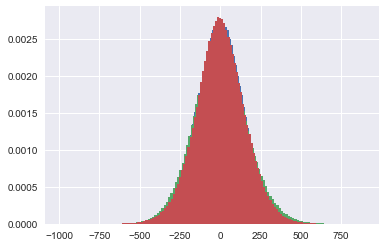

In [68]:
#_= plt.hist(vel_x.flatten(), bins=130, density=True)
#_= plt.hist(vel_x_grid.flatten(), bins=130, density=True)
_= plt.hist(vel_x_grid_smooth.flatten(), bins=130, density=True)
_= plt.hist(vel_y_grid_smooth.flatten(), bins=130, density=True)
_= plt.hist(vel_z_grid_smooth.flatten(), bins=130, density=True)

In [69]:
v_norm = np.sqrt(vel_x_grid_smooth**2 + vel_y_grid_smooth**2 + vel_z_grid_smooth**2)

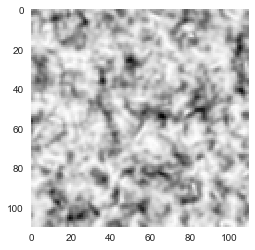

In [70]:
plt.imshow(v_norm[:,:,81])
plt.grid(False)

In [71]:
div_x = np.zeros(np.shape(vel_x_grid_smooth))
div_x[1:-1,:,:] = (vel_x_grid_smooth[2:,:,:] - vel_x_grid_smooth[:-2,:,:])/(2.0*L_cell)
div_x[0,:,:] = (vel_x_grid_smooth[1,:,:] - vel_x_grid_smooth[-1,:,:])/(2.0*L_cell)
div_x[-1,:,:] = (vel_x_grid_smooth[0,:,:] - vel_x_grid_smooth[-2,:,:])/(2.0*L_cell)

div_y = np.zeros(np.shape(vel_y_grid_smooth))
div_y[:,1:-1,:] = (vel_y_grid_smooth[:,2:,:] - vel_y_grid_smooth[:,:-2,:])/(2.0*L_cell)
div_y[:,0,:] = (vel_y_grid_smooth[:,1,:] - vel_y_grid_smooth[:,-1,:])/(2.0*L_cell)
div_y[:,-1,:] = (vel_y_grid_smooth[:,0,:] - vel_y_grid_smooth[:,-2,:])/(2.0*L_cell)

div_z = np.zeros(np.shape(vel_z_grid_smooth))
div_z[:,:,1:-1] = (vel_z_grid_smooth[:,:,2:] - vel_z_grid_smooth[:,:,:-2])/(2.0*L_cell)
div_z[:,:,0] = (vel_z_grid_smooth[:,:,1] - vel_z_grid_smooth[:,:,-1])/(2.0*L_cell)
div_z[:,:,-1] = (vel_z_grid_smooth[:,:,0] - vel_z_grid_smooth[:,:,-2])/(2.0*L_cell)

div = div_x + div_y + div_z

#div_x[0,1:-1,1:-1] = (vel_x_grid_smooth[1,1:-1,1:-1] - vel_x_grid_smooth[-1,1:-1,1:-1])/(2.0*L_cell)
#div_x[1:-1,0,1:-1] = (vel_x_grid_smooth[1,1:-1,1:-1] - vel_x_grid_smooth[-1,1:-1,1:-1])/(2.0*L_cell)

np.save('div_test.npy', div)
div = np.load('div_test.npy')

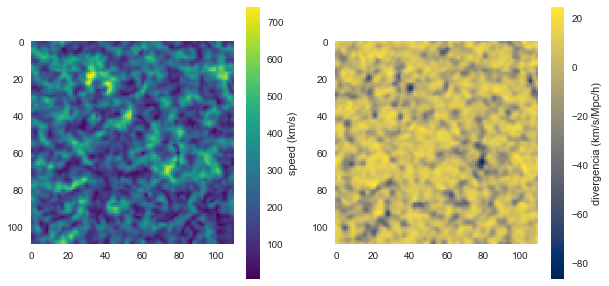

In [72]:
z_slice = 81
plt.figure(figsize=(10,5))


plt.subplot(1,2,1)
plt.imshow(v_norm[z_slice,:,:], cmap='viridis')
plt.grid(False)
plt.colorbar(label='speed (km/s)')


plt.subplot(1,2,2)
plt.imshow(div[z_slice,:,:], cmap='cividis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')

In [74]:
sort_index = np.argsort(div.flatten(order='C'))
watershed_group = np.ones((N_side,N_side,N_side), dtype=int)*-1

n_group = 0
n_cell = 0
for l in range(len(sort_index)):
    n_cell += 1
    ijk = np.unravel_index(sort_index[l], (N_side,N_side,N_side), order='C')
    #print(ijk, n_group, div[ijk])
    #print(tuple(np.array(ijk)))
    #print(type(ijk))
    groups = []
    for i in [-1,0, 1]:
        for j in [-1,0, 1]:
            for k in [-1,0, 1]:
                ijk_test = tuple((np.array(ijk)+(i, j, k))%N_side)
                groups.append(watershed_group[ijk_test])
    c = Counter(groups)
    
    if -1 in c.keys():
        c.pop(-1)
    #print(groups, len(groups), c)
    if len(c)==0:
        watershed_group[ijk] = n_group
        n_group += 1
    else:
        #print("hola")
        #watershed_gr
        g = c.most_common(1)
        watershed_group[ijk] = g[0][0]
        #print(groups, len(groups), c, g[0][0])
        
    if((n_cell%100000)==0):
        print(n_cell,n_group)

100000 3352
200000 4278
300000 4735
400000 5025
500000 5206
600000 5306
700000 5387
800000 5464
900000 5508
1000000 5537
1100000 5575
1200000 5592
1300000 5595


In [75]:
np.save('my_pert_test.npy', watershed_group)

156


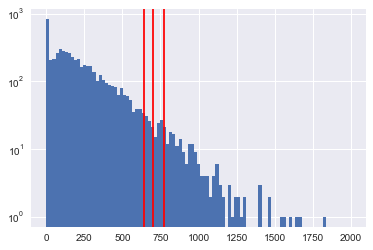

In [98]:
volume_laniakea = 4*((180*0.7/2)/L_cell)**3
f = watershed_group.flatten()
f = f[f!=-1]
c = Counter(f)
_= plt.hist(c.values(), log=True, bins=np.linspace(0,2000,100))

volume_laniakea = 4*((160*0.7/2)/L_cell)**3
plt.axvline(x=volume_laniakea, color='red')
volume_laniakea_min = 4*((155*0.7/2)/L_cell)**3
plt.axvline(x=volume_laniakea_min, color='red')
volume_laniakea_max = 4*((165*0.7/2)/L_cell)**3
plt.axvline(x=volume_laniakea_max, color='red')

n_laniakea = np.count_nonzero((np.array(list(c.values()))<volume_laniakea_max) & (np.array(list(c.values()))>volume_laniakea_min))
print(n_laniakea)

In [5]:
watershed_group = np.load('pert_test.npy')

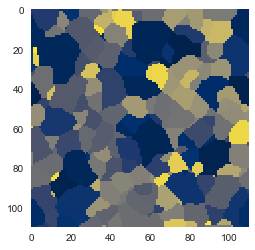

In [49]:
z_slice = 40
plt.imshow(watershed_group[:,:,z_slice], cmap='cividis')
plt.grid(False)

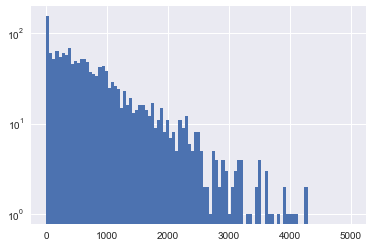

In [11]:
f = watershed_group.flatten()
f = f[f!=-1]
c = Counter(f)
_= plt.hist(c.values(), log=True, bins=np.linspace(0,5000,100))

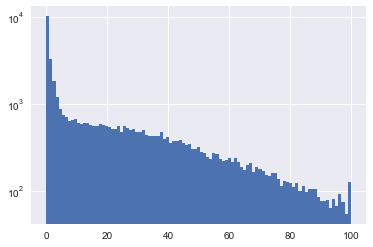

In [368]:
f = watershed_group.flatten()
f = f[f!=-1]
c = Counter(f)
_= plt.hist(c.values(), log=True, bins=np.linspace(0,100,100))

In [78]:
4*((160*0.7/2)/L_cell)**3

702.4639999999998

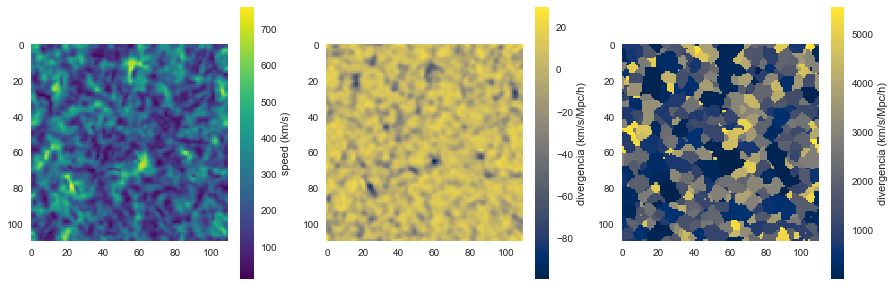

In [100]:
z_slice = 40
plt.figure(figsize=(15,5))


plt.subplot(1,3,1)
plt.imshow(v_norm[:,:,z_slice], cmap='viridis')
plt.grid(False)
plt.colorbar(label='speed (km/s)')


plt.subplot(1,3,2)
plt.imshow(div[:,:,z_slice], cmap='cividis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')


plt.subplot(1,3,3)
plt.imshow(watershed_group[:,:,z_slice], cmap='cividis')
plt.grid(False)
plt.colorbar(label='divergencia (km/s/Mpc/h)')



In [260]:
c

Counter()

In [261]:
len(c)

0

In [274]:
c.most_common()

[]

In [373]:
1100/(49303**0.33)

31.098860836141835